Findings:

Hypothesis 1 of 4:

H0: Discounts do not have a statistically significant effect on the quantity of product ordered.

H1: Discounts DO have a statistically significant effect on the quantity of product ordered. 

Result: Reject the H0

Statistics: KS2 Statistic/P-Value (.12/.0476), Monte Carlo Method Means (Discounted: 27.1/Non-Discounted: 21.71),  Cohen's D (8.91), Anova Method (P-Value: 5 Categories Under .001)

---------------------------------------------------------------------------------------------------------------------

Hypothesis 2 of 4:

H0: Discounts do not have a statistically significant effect on the avg revenue.

H1: Discounts DO have a statistically significant effect on the avg revenue.

Result: Accept the H0

Statistics: KS2 Statistic/P-Value (.033/.0063), Monte Carlo Method Means (Discounted: 52.59/Non-Discounted: 52.32),  Cohen's D (.14)

---------------------------------------------------------------------------------------------------------------------

Hypothesis 3 of 4:


H0: Customers do not have a statistically signifigant bias towards purchasing discounted products.

H1: Customers DO have a statistically signifigant bias towards purchasing discounted products.

Result: Reject the H0

Statistics: KS Statistic/P-Value (.52/0.0), Cohen's D (1.55)

---------------------------------------------------------------------------------------------------------------------

Hypothesis 4 of 4:
    
H0: The perfect order fulfillment is NOT at or above the acceptable standard of 90%.

H1: The perfect order fulfillment is at or above the acceptable standard of 90%.

Result: Reject the H0

Statistics: POF Index: 95%

---------------------------------------------------------------------------------------------------------------------

Each hypothesis has the full process and all details provided below.

---------------------------------------------------------------------------------------------------------------------

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [27]:
c.execute('''select * from OrderDetail''')
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

# Here I am testing the hypothesis given: 
# Ho: Discounts do not have a statistically significant effect on the quantity of product ordered.
# H1: Discounts DO have a statistically significant effect on the quantity of product ordered. 

#Here I am getting the data needed to test the hypothesis.

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [3]:
nddf = df.loc[df.Discount == 0]
ddf = df.loc[df.Discount > 0]

# Seperating data into dataframes based on whether they had a discount on the order or not

In [4]:
ddf.describe(), nddf.describe()

# Taking a look into each dataframes. From this it appears that there is higher amount ordered when there is a 
# discount and the unit price doesn't seem to drop as I had anticipated. The dataframe with the discount actually
# has a higher mean in regards to the unit price. I am going to have to see if the discount is reflected in the unit
# price with the SQL documentation. 

(            OrderId   ProductId   UnitPrice    Quantity    Discount
 count    838.000000  838.000000  838.000000  838.000000  838.000000
 mean   10654.007160   39.844869   26.292363   27.109785    0.144439
 std      235.887125   22.046812   30.017214   20.771439    0.071808
 min    10250.000000    1.000000    2.000000    1.000000    0.010000
 25%    10452.250000   21.000000   12.500000   12.000000    0.100000
 50%    10645.000000   40.000000   18.000000   20.000000    0.150000
 75%    10847.000000   59.000000   31.230000   36.000000    0.200000
 max    11077.000000   77.000000  263.500000  130.000000    0.250000,
             OrderId    ProductId    UnitPrice     Quantity  Discount
 count   1317.000000  1317.000000  1317.000000  1317.000000    1317.0
 mean   10662.791951    41.396355    26.171534    21.715262       0.0
 std      244.835366    22.217410    29.717354    17.507493       0.0
 min    10248.000000     1.000000     2.000000     1.000000       0.0
 25%    10448.000000    23.0

In [5]:
ndx = [x for x in nddf.Quantity]
dx = [x for x in ddf.Quantity]

In [6]:
stats.ks_2samp(ndx, dx)

# Results show very little difference between the two distributions and a low p-value indicates
# we can compare the two to test for the hypothesis

Ks_2sampResult(statistic=0.12135050550629461, pvalue=4.763897379538179e-07)

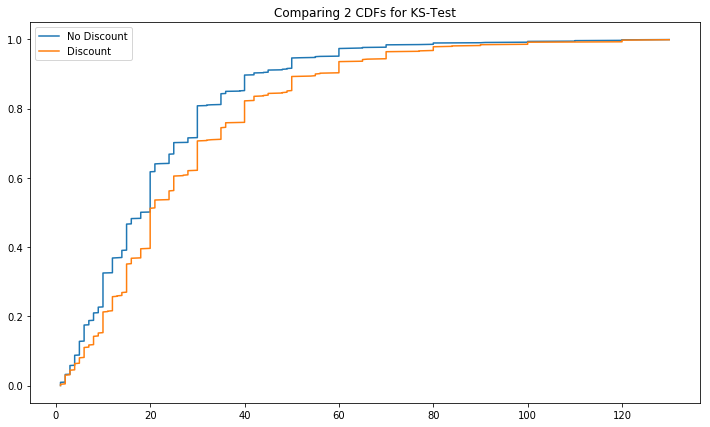

In [7]:
def ks_plot_2sample(data_1, data_2):
    length = len(data_1)
    plt.figure(figsize=(12, 7))
    plt.plot(np.sort(data_1), np.linspace(0, 1, len(data_1), endpoint=False))
    plt.plot(np.sort(data_2), np.linspace(0, 1, len(data_2), endpoint=False))
    plt.legend(['No Discount', 'Discount'])
    plt.title('Comparing 2 CDFs for KS-Test')
    
ks_plot_2sample(ndx, dx)

# Here I am plotting the two CDFs and it shows how similar the distributions are which backs up the low D statistic

In [154]:
def ND_stats(ndx, dx):
    mus1 = []
    devs1 = []
    merger = ndx + dx

    for i in range(10000):
        a = np.random.choice(ndx, size = len(ndx), replace=False)
        b = merger.copy()

        for item in a:
            b.remove(item)

        mu_monte = np.mean(a)
        dev = abs(np.mean(b) - mu_monte)

        mus1.append(mu_monte)
        devs1.append(dev)
    
    return mus1, devs1

# Here I am using a Monte Carlo method to test the sample data against the population as a whole. As you can see
# the model gives a very accurate  representation of the actual discounted data and when compared to the population 
# as a whole which has a deviation of 2.72

In [64]:
mus1, devs1 = ND_stats(ndx, dx)

In [65]:
print("Average quantity sold (Non-Discounted): {}".format(np.mean(mus1)))
print('Average devation from total population: {}'.format(np.mean(devs1)))
print('Average devation from sample population: {}'.format(abs(np.mean(mus1) - np.mean(ndx))))

Average quantity sold (Non-Discounted): 21.7140088
Average devation from total population: 2.7332405981873116
Average devation from sample population: 0.0012531589977236024


In [153]:
def Disc_stats(ndx, dx):
    mus = []
    devs = []
    merger = ndx + dx

    for i in range(10000):
        a = np.random.choice(dx, size = len(dx), replace=False)
        b = merger.copy()

        for item in a:
            b.remove(item)

        mu_monte = np.mean(a)
        dev = abs(np.mean(b) - mu_monte)

        mus.append(mu_monte)
        devs.append(dev)
    
    return mus, devs

# Here I am using a Monte Carlo method to test the sample data against the population as a whole. As you can see
# the model gives a very accurate  representation of the actual discounted data and when compared to the population 
# as a whole which has a deviation of 4.29

In [12]:
mus, devs = Disc_stats(ndx, dx)

In [13]:
print("Average quantity sold (Discounted): {}".format(np.mean(mus)))
print('Average devation from total population: {}'.format(np.mean(devs)))
print('Average devation from sample population: {}'.format(abs(np.mean(mus) - np.mean(dx))))

Average quantity sold (Discounted): 27.0971988
Average devation from total population: 4.27641293897281
Average devation from sample population: 0.012586402863959734


In [23]:
def Cohen_d(group1, group2):

    diff = np.mean(group1) - np.mean(group2)

    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    

    d = diff / np.sqrt(pooled_var)
    
    return d

# Here I am calculating the effect size of the difference between the results with Cohen's D. As you can see
# with the standardized effect size, this shows that there is a Discounts have a large effect on the Quantity sold

In [15]:
Cohen_d(mus, mus1)

8.917313842911296

In [16]:
d_df = df.iloc[:,4:5]
changer = {0.0: 'Zero', 0.01: 'One', 0.02: 'Two', 0.03: 'Three', 0.04: 'Four', 0.05: 'Five', 0.06: 'Six',
           0.1: 'Ten', 0.15: 'Fifteen', 0.2: 'Twenty', 0.25: 'TwentyFive'}

cols = [changer[x] for x in changer]

dd_df = pd.get_dummies(df['Discount'])
dd_df.columns = cols

d_df = pd.concat([d_df, dd_df], axis=1)

d_df.head()

,Quantity,Zero,One,Two,Three,Four,Five,Six,Ten,Fifteen,Twenty,TwentyFive
0,12,1,0,0,0,0,0,0,0,0,0,0
1,10,1,0,0,0,0,0,0,0,0,0,0
2,5,1,0,0,0,0,0,0,0,0,0,0
3,9,1,0,0,0,0,0,0,0,0,0,0
4,40,1,0,0,0,0,0,0,0,0,0,0


In [17]:
formula = 'Quantity ~ C(Zero) + C(One) + C(Two) + C(Three) + C(Four) + C(Five) + C(Six) + C(Ten) + C(Fifteen) + C(Twenty) + C(TwentyFive)'
lm = ols(formula, d_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

# Here I used the ANOVA method to see the effect of disounts on the quantity sold. As shown below the discounts
# do have a significant influence on the quantity sold. Not all of them, just 5% and 10% and above. 

                      sum_sq      df          F    PR(>F)
C(Zero)          2201.012431     1.0   6.224395  0.012675
C(One)            165.732104     1.0   0.468685  0.493667
C(Two)            321.435965     1.0   0.909011  0.340484
C(Three)          494.490733     1.0   1.398405  0.237122
C(Four)           194.656068     1.0   0.550481  0.458202
C(Five)          6317.579398     1.0  17.865919  0.000025
C(Six)            165.732104     1.0   0.468685  0.493667
C(Ten)           4032.122726     1.0  11.402719  0.000746
C(Fifteen)       6489.102659     1.0  18.350982  0.000019
C(Twenty)        5348.649079     1.0  15.125814  0.000104
C(TwentyFive)    6341.809702     1.0  17.934442  0.000024
Residual       758141.232591  2144.0        NaN       NaN


--------------------------------------------------------------------------------------------------------------------

In [18]:
# Here I am testing the hypothesis: 
# Ho: Discounts do not have a statistically significant effect on the avg revenue.
# H1: Discounts DO have a statistically significant effect on the avg revenue.

In [19]:
c.execute("""select * from orderdetail;""")

ndf = pd.DataFrame(c.fetchall())
ndf.columns = [i[0] for i in c.description]
ndf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [20]:
for idx, i in enumerate(ndf.Discount):
    p = ndf.UnitPrice
    q = ndf.Quantity[idx] 
    ndf['Order Total'] = round(p * q * (1 - i), 2)

In [21]:
ndf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Order Total
0,10248/11,10248,11,14.0,12,0.0,28.0
1,10248/42,10248,42,9.8,10,0.0,19.6
2,10248/72,10248,72,34.8,5,0.0,69.6
3,10249/14,10249,14,18.6,9,0.0,37.2
4,10249/51,10249,51,42.4,40,0.0,84.8


In [22]:
cat = np.sort([x for x in ndf.Discount.unique()])

cats = {}
ords = {}

for i in cat:
    cats[i] = 0
    ords[i] = 0

for idx, i in enumerate(ndf.Discount):
    cats[i] += ndf['Order Total'][idx]
    ords[i] += ndf['Quantity'][idx]

In [23]:
disc_total = 0
disc_rev = 0

for i in ords:
    if ords[i] != 28599:
        disc_total += ords[i]
        disc_rev += cats[i]

In [24]:
print("The total number of products sold that were not discounted: {}".format(ords[0]))
print("The total number of products sold that were discounted: {}".format(disc_total))
print("The total revenue brought in by non-discounted products is: {}".format(round(cats[0], 2)))
print("The total revenue brought in by discounted products is: {}".format(round(disc_rev, 1)))

#Here I am taking a look at the raw data when it comes to the hypothesis being tested. Based off what I am seeing
# there is not going to be a statistically signifigant difference as I predicted. 

The total number of products sold that were not discounted: 28599
The total number of products sold that were discounted: 22718
The total revenue brought in by non-discounted products is: 68935.82
The total revenue brought in by discounted products is: 44066.0


In [25]:
nd = ndf.loc[ndf.Discount == 0]
dd = ndf.loc[ndf.Discount > 0]

In [26]:
ndt = [x for x in nd['Order Total']]
dt = [x for x in dd['Order Total']]

Ks_2sampResult(statistic=0.03294262834278383, pvalue=0.6278127992612477)


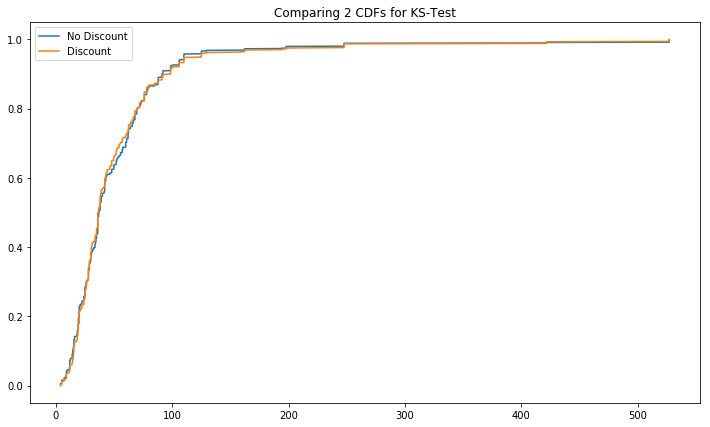

In [27]:
print(stats.ks_2samp(ndt, dt))
ks_plot_2sample(ndt, dt)

In [28]:
mus1, dev1 = ND_stats(ndt, dt)
mus, dev = Disc_stats(ndt, dt)

In [29]:
Cohen_d(mus, mus1)

0.142239811679643

In [30]:
print("Average dollar amount spent (Non-Discounted): {}".format(np.mean(mus1)))
print('Average devation from total population: {}'.format(np.mean(devs1)))
print('Average devation from sample population: {}'.format(abs(np.mean(mus1) - np.mean(ndt))))

Average dollar amount spent (Non-Discounted): 52.323075496
Average devation from total population: 2.726913884592145
Average devation from sample population: 0.01999208182839851


In [31]:
print("Average dollar amount spent (Discounted): {}".format(np.mean(mus)))
print('Average devation from total population: {}'.format(np.mean(devs)))
print('Average devation from sample population: {}'.format(abs(np.mean(mus) - np.mean(dt))))

Average dollar amount spent (Discounted): 52.594981744
Average devation from total population: 4.27641293897281
Average devation from sample population: 0.010256207007159901


In [32]:
# Here I have confirmed that the two datasets that I am analyzing are from similar distributions.
# After that, I have confirmed my initial assessment of the data: there is not a statistically signifigant
# difference between the two datasets. Here we would have to accept the null hypothesis and reject my hypothesis
# that providing a discount will affect the avg revenue brought in per sale. 

---------------------------------------------------------------------------------------------------------------------

In [179]:
# Here I am testing the hypothesis: 
# Ho: Customers do not have a statistically signifigant bias towards purchasing discounted products.
# H1: Customers DO have a statistically signifigant bias towards purchasing discounted products.

In [14]:
c.execute('''select * from OrderDetail join "Order" on OrderDetail.OrderID = "Order".Id join 
             Customer on "Order".CustomerID = Customer.Id;''')

pdf = pd.DataFrame(c.fetchall())
pdf.columns = [x[0] for x in c.description]
pdf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,CustomerId,EmployeeId,OrderDate,...,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,10248/11,10248,11,14.0,12,0.0,10248,VINET,5,2012-07-04,...,Vins et alcools Chevalier,Paul Henriot,Accounting Manager,59 rue de l'Abbaye,Reims,Western Europe,51100,France,26.47.15.10,26.47.15.11
1,10248/42,10248,42,9.8,10,0.0,10248,VINET,5,2012-07-04,...,Vins et alcools Chevalier,Paul Henriot,Accounting Manager,59 rue de l'Abbaye,Reims,Western Europe,51100,France,26.47.15.10,26.47.15.11
2,10248/72,10248,72,34.8,5,0.0,10248,VINET,5,2012-07-04,...,Vins et alcools Chevalier,Paul Henriot,Accounting Manager,59 rue de l'Abbaye,Reims,Western Europe,51100,France,26.47.15.10,26.47.15.11
3,10249/14,10249,14,18.6,9,0.0,10249,TOMSP,6,2012-07-05,...,Toms Spezialitäten,Karin Josephs,Marketing Manager,Luisenstr. 48,Münster,Western Europe,44087,Germany,0251-031259,0251-035695
4,10249/51,10249,51,42.4,40,0.0,10249,TOMSP,6,2012-07-05,...,Toms Spezialitäten,Karin Josephs,Marketing Manager,Luisenstr. 48,Münster,Western Europe,44087,Germany,0251-031259,0251-035695


In [15]:
pdf = pdf.drop(['Id', 'ProductId', 'CustomerId', 'EmployeeId', 'OrderDate', 'ShippedDate', 'ShipVia', 'ShipName', 'ShipAddress', 'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry', 'Phone', 'Fax', 'Country', 'PostalCode', 'Region', 'City', 'Address', 'ContactTitle', 'ContactName'], axis=1)
pdf.head()

#I am simplifying the dataframe to make it easier to work with

,OrderId,UnitPrice,Quantity,Discount,RequiredDate,Freight,CompanyName
0,10248,14.0,12,0.0,2012-08-01,32.38,Vins et alcools Chevalier
1,10248,9.8,10,0.0,2012-08-01,32.38,Vins et alcools Chevalier
2,10248,34.8,5,0.0,2012-08-01,32.38,Vins et alcools Chevalier
3,10249,18.6,9,0.0,2012-08-16,11.61,Toms Spezialitäten
4,10249,42.4,40,0.0,2012-08-16,11.61,Toms Spezialitäten


In [16]:
len(pdf.CompanyName.unique())

# Number of Companies that have made purchases

85

In [17]:
disc_dict = {}
disc_buyers = []

for i in pdf.CompanyName.unique():
    df = pdf.groupby(['CompanyName'])
    w = df.get_group(i)
    
    d = w.loc[w['Discount'] == 0]
    d_sum = d.Quantity.sum()
    
    nd = w.loc[w['Discount'] > 0]
    nd_sum = nd.Quantity.sum()
    
    
    disc_dict[i] = [d_sum,nd_sum]
    
# Here I am creating a dictionary with the total quantity purchased by each Customer for and seperating them by
# whether the product was discounted or not

In [18]:
dis = [round(int(disc_dict[x][0])/(int(disc_dict[x][0])+int(disc_dict[x][1])), 2) for x in disc_dict]
ndis = [round(int(disc_dict[x][1])/(int(disc_dict[x][0])+int(disc_dict[x][1])), 2) for x in disc_dict]

# This is each companies percentage of goods purchased that were discounted and that weren't discounted

In [19]:
np.std(dis)

0.26323576076199195

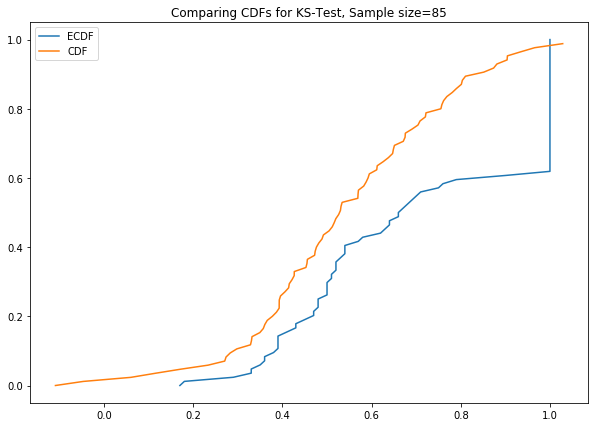

In [20]:
def ks_plot(data):

    plt.figure(figsize=(10, 7))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint= 1))
    plt.plot(np.sort(stats.norm.rvs(loc=.5, scale=.26, size=len(data))), np.linspace(0, 1, len(data), endpoint=False))

    plt.legend(['ECDF', 'CDF'])
    plt.title('Comparing CDFs for KS-Test, Sample size=' + str(len(data)))
    

ks_plot(dis)

# Here I am plotting the distribution of discounted quantity percentages per company against a normal distribution 
# and it clearly shows that the discounted percentages are not normally distributed.

In [21]:
stats.kstest(dis, 'norm', args=(0, 3))

# Here I am running a KS test to confirm that we can reject the null hypothesis with a high level of certainty

KstestResult(statistic=0.5225946362615375, pvalue=0.0)

In [24]:
Cohen_d(dis, ndis)

# Here is Cohen's D statistic as a standardized effect size which indicates that there is a very large effect

1.5454721206348538

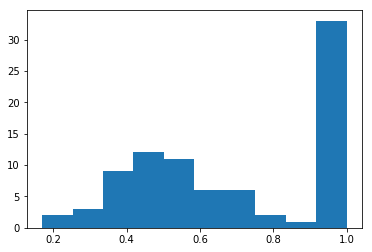

In [223]:
plt.hist(dis);

# I plotted the data as a histogram to further look into the unusual plot that was shown above. This shows that there
# is a signifigant amount of Customers that ONLY order discounted goods. This is why the distribution is skewed and 
# is not a normal distribution.

In [224]:
for i in disc_dict:
    a = disc_dict[i][0]
    b = disc_dict[i][1]
    cc = a / (a + b)
    if cc >= .70:
        disc_buyers.append(i)
        
len(disc_buyers)

# This is just for practical purposes. I am finding which Customers are at or above the mean (70%) of their
# goods purchased being discounted. As shown below, there are 39 Customers that purchase discounted goods 70% of the 
# time which is 45% of customers.

39

In [225]:
len(disc_buyers)/85

0.4588235294117647

In [227]:
# Given the data above, we can reject the null hypothesis with a high degree of confidence and say that customers
# have a high bias towards purchasing discounted goods.

---------------------------------------------------------------------------------------------------------------------

In [45]:
# Here I am testing a common hypothesis for supply chain order fulfillment: 
# Ho: The perfect order fulfillment is NOT at or above the acceptable standard of 90%.
# H1: The perfect order fulfillment is at or above the acceptable standard of 90%.

In [41]:
c.execute('''select * from Product;''')

xdf = pd.DataFrame(c.fetchall())
xdf.columns = [x[0] for x in c.description]
xdf.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [42]:
tot_ord = sum(xdf.UnitsOnOrder)

In [43]:
mo = xdf.loc[xdf['UnitsInStock'] < xdf['UnitsOnOrder']]
mo.head(14)

# Here I have gotten the amount of UnitsOnOrder and then filtered out the Products that are able to be fulfilled
# When I was exploring this table I noticed that units in stock were less than those on order so I wanted to
# check the hypothesis mentioned above.

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
10,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0
20,21,Sir Rodney's Scones,8,3,24 pkgs. x 4 pieces,10.00,3,40,5,0
30,31,Gorgonzola Telino,14,4,12 - 100 g pkgs,12.50,0,70,20,0
31,32,Mascarpone Fabioli,14,4,24 - 200 g pkgs.,32.00,9,40,25,0
36,37,Gravad lax,17,8,12 - 500 g pkgs.,26.00,11,50,25,0
44,45,Rogede sild,21,8,1k pkg.,9.50,5,70,15,0
47,48,Chocolade,22,3,10 pkgs.,12.75,15,70,25,0
48,49,Maxilaku,23,3,24 - 50 g pkgs.,20.00,10,60,15,0


In [44]:
14/77

# Initial results do not look promising as almost 20% of Products do not have enough stock to fulfill the orders needed

0.18181818181818182

In [52]:
bo = {}

for i in mo.CategoryId.unique():
    df = mo.groupby(['CategoryId'])
    w = df.get_group(i)
    idx = [x - 1 for x in w.Id.unique()]
    
    for j in idx:
        a = w.UnitsInStock[j]
        b = w.UnitsOnOrder[j]
        cc = w.UnitPrice[j]
        d = b - a
        e = d * cc
    
    bo[i] = [d,e]
    
# Here I am creating a dictionary that breaks down which category as well as the quantity and dollar amount that 
# is unable to be fulfilled/collected on. The reason for this is so that if needed, new suppliers can be found in 
# this category to ensure a positive customer experience.

In [53]:
quant = []
loss = []

for i in mo.CategoryId.unique():
    quant.append(bo[i][0])
    loss.append(bo[i][1])
    
quant = sum(quant)
loss = sum(loss)
    
print("The total amount of product that is unable to be paid on is {} from {} units on backorder.".format(loss, quant))

The total amount of product that is unable to be paid on is 5817.0 from 293 units on backorder.


In [54]:
quant/tot_ord

# This is the percentage of units that are on backorder which seems to go against the H0.

0.37564102564102564

In [56]:
bo

# This is the dictionary that I created and as you can see, 3 categories make up the majority of the units that 
# are on backorder. Although I would like to point out that each category has a different unit price so the 
# top three dollar amounts are different from the top 3 units by quantity.

{1: [23, 437.0],
 2: [96, 1632.0],
 4: [31, 992.0],
 3: [4, 50.0],
 8: [65, 617.5],
 5: [58, 1928.5],
 7: [16, 160.0]}

In [59]:
c.execute('''select * from "order" join OrderDetail on "order".Id = OrderDetail.OrderID;''')

zdf = pd.DataFrame(c.fetchall())
zdf.columns = [x[0] for x in c.description]
zdf.head()

# Here I am getting historicals on purchases so that I can perform a POF although it is going to have to be a 
# simplified version as many of the parameters are not included in this dataset.

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/11,10248,11,14.0,12,0.0
1,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/42,10248,42,9.8,10,0.0
2,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/72,10248,72,34.8,5,0.0
3,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/14,10249,14,18.6,9,0.0
4,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/51,10249,51,42.4,40,0.0


In [60]:
missed = zdf.loc[zdf['RequiredDate'] <= zdf['ShippedDate']]
missed.head()

# This df is all orders that were not able to be shipped out in time for reasons that are not specified in this 
# dataframe although it is safe to assume if an order is not shipped out before the required date, the product
# was not in stock and was shipped as soon as it was available. 

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
47,10264,FOLKO,6,2012-07-24,2012-08-21,2012-08-23,3,3.67,Folk och fä HB,Åkergatan 24,Bräcke,Northern Europe,S-844 67,Sweden,10264/2,10264,2,15.2,35,0.00
48,10264,FOLKO,6,2012-07-24,2012-08-21,2012-08-23,3,3.67,Folk och fä HB,Åkergatan 24,Bräcke,Northern Europe,S-844 67,Sweden,10264/41,10264,41,7.7,25,0.15
61,10271,SPLIR,6,2012-08-01,2012-08-29,2012-08-30,2,4.54,Split Rail Beer & Ale,P.O. Box 555,Lander,North America,82520,USA,10271/33,10271,33,2.0,24,0.00
83,10280,BERGS,2,2012-08-14,2012-09-11,2012-09-12,1,8.98,Berglunds snabbköp,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,10280/24,10280,24,3.6,12,0.00
84,10280,BERGS,2,2012-08-14,2012-09-11,2012-09-12,1,8.98,Berglunds snabbköp,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,10280/55,10280,55,19.2,20,0.00


In [61]:
p = len(missed.OrderId.unique())

In [67]:
u = len(zdf.OrderId.unique())

In [70]:
abs(((p / u) * 1) - 1)

# Here is the simplified version as we do not have info such as whether the package arrived damaged and other 
# percentages needed to calculate the POF. Based on the data, we see that the orders are recieved before their 
# required date 95% of the time. Well above industry standard. 

0.9518072289156626

In [ ]:
# Given the information above, we can reject the null hypothesis. While the initial data did not look promising, it 
# turns out that even though there are a lot of products on backorder, the products tend to get to thier destination 
# before they are needed 95% of the time. 